In [1]:
using  GridapGmsh
using  Gridap
using  Gridap.Geometry
using  Gridap.TensorValues
using  Plots
using LinearAlgebra
using LineSearches: BackTracking
using Gridap.Arrays
using Gridap.ReferenceFEs

In [2]:
const  E_mat = 20.8
const  ν_mat = 0.3
const  Gc = 5e-4
const  ls = 0.06
const  η = 1e-15

1.0e-15

In [3]:
parent_path = "./fatigueresults$ls/"     # Go up one level and define the new folder name
mkpath(parent_path)

"./fatigueresults0.06"

In [4]:
cd("fatigueresults$ls")

In [4]:
using  Gmsh: gmsh
const  L = 8.0
const  LL = 0.475.*L
const  LR = 0.525.*L
const  H = 2.0
const  CH = 0.4 #Crack  height
const  CW = 0.2 #Crack  Width
const  hfc = 0.03/100 #Mesh  size  parameter
const  hf = 0.03/5 #Mesh  size  parameter
const  h = 50*hf #Mesh  size  parameter
gmsh.initialize()
gmsh.option.setNumber("General.Terminal", 1)
gmsh.model.geo.addPoint((L/2)+(CW/2), 0.0 , 0.0, hf ,1)
gmsh.model.geo.addPoint(L, 0.0, 0.0, h, 2)
gmsh.model.geo.addPoint(L, H, 0.0, h, 3)
gmsh.model.geo.addPoint(LR , H, 0.0, hf, 4)
gmsh.model.geo.addPoint(LL , H, 0.0, hf, 5)
gmsh.model.geo.addPoint(0.0, H, 0.0, h, 6)
gmsh.model.geo.addPoint(0.0, 0.0, 0.0, h, 7)
gmsh.model.geo.addPoint((L/2) -(CW/2), 0.0 , 0.0, hf ,8)
gmsh.model.geo.addPoint((L/2), CH , 0.0, hfc , 9)
gmsh.model.geo.addLine(1, 2, 1)
gmsh.model.geo.addLine(2, 3, 2)
gmsh.model.geo.addLine(3, 4, 3)
gmsh.model.geo.addLine(4, 5, 4)
gmsh.model.geo.addLine(5, 6, 5)
gmsh.model.geo.addLine(6, 7, 6)
gmsh.model.geo.addLine(7, 8, 7)
gmsh.model.geo.addLine(8, 9, 8)
gmsh.model.geo.addLine(9, 1, 9)

gmsh.model.geo.addCurveLoop([1,2,3,4,5,6,7,8,9],1)
gmsh.model.geo.addPlaneSurface([1], 1)
gmsh.model.addPhysicalGroup(2, [1],1)
gmsh.model.addPhysicalGroup(1, [4],1)
gmsh.model.addPhysicalGroup(0, [7],2)
gmsh.model.addPhysicalGroup(0, [2],3)
gmsh.model.setPhysicalName(2, 1, "Domain")
gmsh.model.setPhysicalName(1, 1, "LoadLine")
gmsh.model.setPhysicalName(0, 2, "LeftSupport")
gmsh.model.setPhysicalName(0, 3, "RightSupport")
gmsh.model.mesh.field.add("Box", 10)
gmsh.model.mesh.field.setNumber(10, "VIn", hf)
gmsh.model.mesh.field.setNumber(10, "VOut", h)
gmsh.model.mesh.field.setNumber(10, "XMin", (L/2)-CW)
gmsh.model.mesh.field.setNumber(10, "XMax", (L/2)+CW)
gmsh.model.mesh.field.setNumber(10, "YMin", 0)
gmsh.model.mesh.field.setNumber(10, "YMax", H)
gmsh.model.mesh.field.setAsBackgroundMesh(10)
gmsh.model.geo.synchronize()
gmsh.model.mesh.generate(2)
gmsh.write("BeamWithNotchSymThreePtBending.msh")
gmsh.finalize()

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 30%] Meshing curve 3 (Line)
Info    : [ 40%] Meshing curve 4 (Line)
Info    : [ 50%] Meshing curve 5 (Line)
Info    : [ 60%] Meshing curve 6 (Line)
Info    : [ 70%] Meshing curve 7 (Line)
Info    : [ 80%] Meshing curve 8 (Line)
Info    : [ 90%] Meshing curve 9 (Line)
Info    : Done meshing 1D (Wall 0.0197711s, CPU 0.019762s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.86551s, CPU 0.85729s)
Info    : 31659 nodes 63325 elements
Info    : Writing 'BeamWithNotchSymThreePtBending.msh'...
Info    : Done writing 'BeamWithNotchSymThreePtBending.msh'


In [5]:
model = GmshDiscreteModel("BeamWithNotchSymThreePtBending.msh")
writevtk(model ,"BeamWithNotchSymThreePtBending")
     

Info    : Reading 'BeamWithNotchSymThreePtBending.msh'...
Info    : 19 entities
Info    : 31659 nodes
Info    : 62650 elements
Info    : Done reading 'BeamWithNotchSymThreePtBending.msh'


3-element Vector{Vector{String}}:
 ["BeamWithNotchSymThreePtBending_0.vtu"]
 ["BeamWithNotchSymThreePtBending_1.vtu"]
 ["BeamWithNotchSymThreePtBending_2.vtu"]

In [6]:
const σc = 0.2 
const m = 3*E_mat*Gc/(4*ls*σc^2)
const ψ_Crit = σc^2 / (2*E_mat)
const kf = 0.5
const αT = ψ_Crit/kf

0.0019230769230769234

In [7]:
function degDer(ϕ)
    g = (m*ϕ)/(0.25*m^2*ϕ^4 - 0.5*m^2*ϕ^2 + 0.25*m^2 - m*ϕ^4 + m*ϕ^2 + ϕ^4) 
    return g
end

degDer (generic function with 1 method)

In [8]:
function  ElasFourthOrderConstTensor(E,ν,PlanarState)
    # 1 for  Plane  Stress  and 2 Plane  Strain  Condition
    if  PlanarState  == 1
        C1111 =E/(1-ν*ν)
        C1122 = (ν*E)/(1-ν*ν)
        C1112 = 0.0
        C2222 =E/(1-ν*ν)
        C2212 = 0.0
        C1212 =E/(2*(1+ν))
    elseif  PlanarState  == 2
        C1111 = (E*(1-ν*ν))/((1+ν)*(1-ν-2*ν*ν))
        C1122 = (ν*E)/(1-ν-2*ν*ν)
        C1112 = 0.0
        C2222 = (E*(1-ν))/(1-ν-2*ν*ν)
        C2212 = 0.0
        C1212 =E/(2*(1+ν))
    end
    C_ten = SymFourthOrderTensorValue(C1111 ,C1112 ,C1122 ,C1112 ,C1212 ,C2212 ,C1122 ,C2212 ,C2222)
    return   C_ten
end
     

const  C_mat = ElasFourthOrderConstTensor(E_mat ,ν_mat ,2)
     

SymFourthOrderTensorValue{2, Float64, 9}(28.0, 0.0, 12.0, 0.0, 8.0, 0.0, 12.0, 0.0, 27.999999999999996)

In [9]:
I2 = SymTensorValue{2,Float64}(1.0 ,0.0 ,1.0)
I4 = I2⊗I2
I4_sym = one(SymFourthOrderTensorValue{2,Float64})
P_vol = (1.0/2)*I4
P_dev = I4_sym  - P_vol
     

SymFourthOrderTensorValue{2, Float64, 9}(0.5, 0.0, -0.5, 0.0, 0.5, 0.0, -0.5, 0.0, 0.5)

In [10]:
function σfun(ε,ε_in,s_in)
    σ_elas = C_mat⊙ε
    gs = (s_in^2) / (s_in^2 + m*(1-s_in)*(0.5+0.5*s_in))
    if tr(ε_in) >= 0
        σ = (gs)*σ_elas
    elseif  tr(ε_in) < 0
        σ = (gs)*P_dev ⊙ σ_elas + P_vol ⊙ σ_elas
    end
    return  σ
end
     

σfun (generic function with 1 method)

In [11]:
function ψPos(ε_in,Fdg)
   σ_elas = C_mat⊙ε_in
    if tr(ε_in) >= 0
        ψPlus = 0.5*(ε_in ⊙ σ_elas)/(Fdg)
    elseif  tr(ε_in) < 0
        ψPlus = 0.5*((P_dev ⊙ σ_elas)⊙(P_dev⊙ε_in))/(Fdg)
    end
    return ψPlus
end

function ψPosOrg(ε_in)
   σ_elas = C_mat⊙ε_in
    if tr(ε_in) >= 0
        ψPlus = 0.5*(ε_in ⊙ σ_elas)
    elseif  tr(ε_in) < 0
        ψPlus = 0.5*((P_dev ⊙ σ_elas)⊙(P_dev⊙ε_in))
    end
    return ψPlus
end

ψPosOrg (generic function with 1 method)

In [12]:
function  new_EnergyState(ψPlusPrev_in,ψhPos_in)
    ψPlus_in = ψhPos_in
    if ψPlus_in  >=ψPlusPrev_in
        ψPlus_out =ψPlus_in
    else
        ψPlus_out=ψPlusPrev_in
    end
    true,ψPlus_out
end
     

new_EnergyState (generic function with 1 method)

In [13]:
function  project(q,model ,dΩ,order)
    reffe = ReferenceFE(lagrangian ,Float64 ,order)
    V = FESpace(model ,reffe ,conformity =:L2)
    a(u,v) =∫(u*v)*dΩ
    b(v) =∫(v*q)*dΩ
    op = AffineFEOperator(a,b,V,V)
    qh = solve(op)
    return  qh
end
     

project (generic function with 1 method)

In [14]:
function FatigueDegrad(αb)
    fdg = @. ifelse(αb >= αT , ((2*αT)/(αb + αT))*((2*αT)/(αb + αT)), 1.0)
    return fdg
end

FatigueDegrad (generic function with 1 method)

In [15]:
function FatiguehistoryVariable(ψhPos_in,αPrev,αbPrev)
    α = ψhPos_in #(s_in ^2 + η)*ψhPos_in
    if α >= αPrev
       αb = αbPrev + abs(α-αPrev)
    else
       αb = αbPrev
    end
return αb
end

FatiguehistoryVariable (generic function with 1 method)

In [16]:
function αNC(s_in,ψhPos_in)
    gs = (s_in^2) / (s_in^2 + m*(1-s_in)*(0.5+0.5*s_in))
    α = gs * ψhPos_in
return α
end

αNC (generic function with 1 method)

In [17]:
order = 1
reffe_PF = ReferenceFE(lagrangian ,Float64,order)
V0_PF = TestFESpace(model ,reffe_PF;conformity =:H1)
U_PF = TrialFESpace(V0_PF)
sh = zero(V0_PF)

SingleFieldFEFunction():
 num_cells: 62581
 DomainStyle: ReferenceDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 6330875882586759360

In [18]:
reffe_Disp = ReferenceFE(lagrangian ,VectorValue{2,Float64},order)
V0_Disp = TestFESpace(model,reffe_Disp;conformity =:H1,
    dirichlet_tags = ["LeftSupport","RightSupport","LoadLine"],
    dirichlet_masks =[(false ,true), (true ,true), (false ,true)])

uh = zero(V0_Disp)

SingleFieldFEFunction():
 num_cells: 62581
 DomainStyle: ReferenceDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 6330875882586759360

In [19]:
degree = 2*order
Ω= Triangulation(model)
dΩ= Measure(Ω,degree)

GenericMeasure()

In [20]:
labels = get_face_labeling(model)
LoadTagId = get_tag_from_name(labels ,"LoadLine")
Γ_Load = BoundaryTriangulation(model ,tags = LoadTagId)
dΓ_Load = Measure(Γ_Load ,degree)
n_Γ_Load = get_normal_vector(Γ_Load)

GenericCellField():
 num_cells: 67
 DomainStyle: ReferenceDomain()
 Triangulation: BoundaryTriangulation()
 Triangulation id: 4614900918876823395

In [21]:
nls = NLSolver(
  show_trace=true,
  method=:newton,
  linesearch=BackTracking(), iterations = 10)
solver = FESolver(nls)

NonlinearFESolver()

In [22]:
function crack_tip_tracker(sh,tol)
    damagetracker = Float64[]
    sVec = Float64[]
    coords = get_node_coordinates(Ω)
    
    sVec = get_free_dof_values(sh)
    
    for i in 1:length(sVec)
        if sVec[i] <= tol
            push!(damagetracker,i)
        end
    end
   damagetracker = round.(Int,damagetracker)
    xloc = Float64[]
    yloc = Float64[]
    if damagetracker!= Float64[]
        for i in 1:length(damagetracker)
            push!(xloc,coords[damagetracker[i]][1])
            push!(yloc,coords[damagetracker[i]][2])
        end
        Locx, index= findmax(xloc)
        Locy = yloc[index]
        return (Locx,Locy)
    else 
       return "No damage"
    end
end

crack_tip_tracker (generic function with 1 method)

In [23]:
function stepPhaseField(x0,vApp,cache,ψPlusPrev_in)
     U_PF = TrialFESpace(V0_PF)
     res(s,ϕ) = ∫( (3/4)*Gc*ls*∇(ϕ)⋅ ∇(s) + (degDer∘(s))*ψPlusPrev_in*ϕ - ((3/8)*Gc/ls)*ϕ)*dΩ
     op = FEOperator(res,U_PF,V0_PF)
     sh_out = FEFunction(U_PF,x0)
     sh_out, cache = solve!(sh_out,solver,op,cache)
  return sh_out, get_free_dof_values(sh_out), cache
end

stepPhaseField (generic function with 1 method)

In [24]:
function  stepDisp(uh_in,sh_in ,vApp)
    uApp1(x) = VectorValue(0.0,0.0)
    uApp2(x) = VectorValue(0.0,0.0)
    uApp3(x) = VectorValue(0.0,-vApp)
    U_Disp = TrialFESpace(V0_Disp ,[uApp1 ,uApp2 ,uApp3])
    a_Disp(u,v) =∫( (ε(v)⊙(σfun∘(ε(u),ε(uh_in),sh_in)) ) )*dΩ
    b_Disp(v) = 0.0
    op_Disp = AffineFEOperator(a_Disp ,b_Disp ,U_Disp ,V0_Disp)
    uh_out = solve(op_Disp)
    return  uh_out
end
     

stepDisp (generic function with 1 method)

In [25]:
vApp = 0
const innerMax = 10
const tol_lim = 0.05
count = 0

const T = 1
const n = 200
const Tₚ = T/n
const n1 = 64 # loadsteps
const delv = 0.025
const tp = Tₚ/n1
t = 0.0
cycle = 0
const dc = 1/n1

Load = Float64[]
Displacement = Float64[]
time = Float64[]
AppDisplacement = Float64[]
αEnergy = Float64[]
αDegrad = Float64[]
FracEnergy = Float64[]

NoofCycles = Float64[]
Xloccrack = Float64[]
Yloccrack = Float64[]


push!(Xloccrack,(L/2))
push!(Yloccrack,CH)
push!(Load, 0.0)
push!(Displacement, 0.0)

push!(time, t)
push!(AppDisplacement, vApp)
push!(NoofCycles, cycle)

push!(αEnergy, 0.0)
push!(αDegrad, 1.0)
push!(FracEnergy, 0.0)

sPrev = CellState(1.0,dΩ)
sh = project(sPrev ,model ,dΩ,order)
x0_PF = ones(Float64,num_free_dofs(V0_PF))
cache_1 = nothing

αPrev = CellState(0.0,dΩ)
αbPrev = CellState(0.0,dΩ)

αhPlusPrev = project(αPrev,model,dΩ,order)
αbhPlusPrev = project(αbPrev,model,dΩ,order)

FdhPrev = FatigueDegrad∘(αbhPlusPrev)

ψPlusPrev = CellState(ψ_Crit,dΩ)

while  t .< T
    t = t + tp
    vAppC = abs(4*delv/Tₚ * abs((((t-Tₚ/4)%Tₚ)+Tₚ)%Tₚ - Tₚ/2) - delv)
    vApp = round(vAppC,digits = 6)
    count = count .+ 1
    cycle = cycle + dc
    FdhPrev = FatigueDegrad∘(αbhPlusPrev)
    
    print("\n Entering  displacemtent  step$count:", float(vApp))
        
    for  inner = 1: innerMax
        ψhPlusPrev = project(ψPlusPrev ,model ,dΩ,order)
        RelErr = abs(sum(∫( (3/4)*Gc*ls*∇(sh)⋅ ∇(sh) + (degDer∘(sh))*ψhPlusPrev*sh)*dΩ-∫( ((3/8)*Gc/ls)*sh)*dΩ))/abs(sum(∫( ((3/8)*Gc/ls)*sh)*dΩ))
        
        println("\n Relative error =", float(RelErr), "\n")
        sh,x0_PF,cache_1 = stepPhaseField(x0_PF,vApp,cache_1,ψhPlusPrev)
        uh = stepDisp(uh,sh,vApp)
        
        ψhPos_in =ψPos∘(ε(uh),FdhPrev)
        
        update_state!( new_EnergyState ,ψPlusPrev ,ψhPos_in)
        if   RelErr  < 1e-6
            break
        end
    end
    
    if  crack_tip_tracker(sh,tol_lim) =="No damage"
        push!(Xloccrack,0.5*L)
        push!(Yloccrack,CH)
    else
        (X_t, Y_t) = crack_tip_tracker(sh,tol_lim)
        push!(Xloccrack,X_t)
        push!(Yloccrack,Y_t)
    end
    
    ψhPosOrg_in = ψPosOrg∘(ε(uh))
    αPrev = αNC∘(sh,ψhPosOrg_in)
    αbPrev = FatiguehistoryVariable∘(αPrev,αhPlusPrev,αbhPlusPrev)
    
    αhPlusPrev = project(αPrev,model,dΩ,order)
    αbhPlusPrev = project(αbPrev,model,dΩ,order)
    
    FdhPrev = FatigueDegrad∘(αbhPlusPrev)
    
    FracEnergyExp = sum(∫((3/8)*((1-sh)/ls + ls*(∇(sh) ⋅ ∇(sh))))*dΩ)
    
    αbPrevVal = evaluate(αbPrev,VectorValue(0.5*L, 2*CH))
    Fdegrad = evaluate(FdhPrev,VectorValue(0.5*L, 2*CH))
    
    push!(time, t)
    push!(AppDisplacement, vApp)
    push!(NoofCycles, cycle)
    
    push!(αEnergy, αbPrevVal)
    push!(αDegrad, Fdegrad)
    push!(FracEnergy, FracEnergyExp)
   
    Node_Force = sum(∫(n_Γ_Load⋅(σfun∘(ε(uh),ε(uh),sh)))*dΓ_Load)
    
    push!(Load , -Node_Force[2])
    push!( Displacement , vApp)
    if mod(count,n1) == 0
        writevtk(Ω,"results_SymThreePtBendingTest$count",cellfields= ["uh"=>uh,"s"=>sh , "epsi"=>ε(uh),"Fdeg"=> FdhPrev, "alphabar"=> αbhPlusPrev])
    end
 end     


 Entering  displacemtent  step1:0.001562
 Relative error =8.209760686415742e-17

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.191226e-20              NaN

 Entering  displacemtent  step2:0.003125
 Relative error =4.3313522365664546e-17

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.191226e-20              NaN

 Entering  displacemtent  step3:0.004687
 Relative error =2.184812089274188e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.357073e-10              NaN

 Entering  displacemtent  step4:0.00625
 Relative error =1.3402464228621276e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.524085e-09              NaN

 Entering  displacemtent  step5:0.007812
 Relative error =7.315621174777746e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     8.644908e-09     


 Relative error =4.782084626594014e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.754933e-06              NaN
     1     3.078498e-09     6.986734e-01

 Relative error =2.1269672429067054e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.158054e-06              NaN
     1     1.080801e-09     1.507503e-01

 Relative error =1.120462060552744e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     8.313803e-07              NaN
     1     4.688276e-10     4.691044e-02

 Relative error =6.6004855804323616e-6

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.669154e-07              NaN
     1     2.138114e-10     1.763278e-02

 Relative error =4.146486804090531e-6

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.591377e-07              NaN
     1     1.001151e-10     7


 Entering  displacemtent  step33:0.001563
 Relative error =7.03953837278937e-11

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.883534e-13              NaN

 Entering  displacemtent  step34:0.003125
 Relative error =7.03953837278937e-11

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.883534e-13              NaN

 Entering  displacemtent  step35:0.004688
 Relative error =7.03953837278937e-11

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.883534e-13              NaN

 Entering  displacemtent  step36:0.00625
 Relative error =7.03953837278937e-11

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.883534e-13              NaN

 Entering  displacemtent  step37:0.007813
 Relative error =7.03953837278937e-11

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.883534e-13    


 Relative error =3.770247250592086e-6

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.149300e-07              NaN
     1     3.345168e-11     2.578328e-03

 Relative error =2.9954578776503294e-6

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.668818e-07              NaN
     1     2.080807e-11     1.623224e-03

 Entering  displacemtent  step48:0.025
 Relative error =2.3688506032226396e-6

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.240683e-07              NaN
     1     1.261880e-11     1.009400e-03

 Relative error =4.580579640863485e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.913798e-07              NaN
     1     6.834688e-10     2.125893e-01

 Relative error =2.653669617699222e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.418065e-07        

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.997804e-09              NaN

 Entering  displacemtent  step76:0.01875
 Relative error =3.071193093184965e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.997804e-09              NaN

 Entering  displacemtent  step77:0.020313
 Relative error =3.071193093184965e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.997804e-09              NaN

 Entering  displacemtent  step78:0.021875
 Relative error =6.3456169676313946e-6

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.470824e-08              NaN
     1     5.293052e-11     6.239437e-03

 Relative error =3.0228100869437913e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.893744e-07              NaN
     1     8.037769e-10     1.095767e-01

 Relative error =1.903596

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.824987e-07              NaN
     1     1.319304e-10     5.603282e-03

 Relative error =7.660277789485773e-6

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.019012e-07              NaN
     1     8.657716e-11     3.823181e-03

 Relative error =6.290104392867516e-6

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.226175e-07              NaN
     1     5.961776e-11     2.591734e-03

 Entering  displacemtent  step112:0.025
 Relative error =5.150464085709293e-6

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.590653e-07              NaN
     1     4.098054e-11     1.745564e-03

 Relative error =5.836450657751232e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.752559e-07              NaN
     1     1.381482e-09     1.4

     0     1.465485e-09              NaN

 Entering  displacemtent  step160:0.0
 Relative error =5.122806576748318e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.465485e-09              NaN

 Entering  displacemtent  step161:0.001563
 Relative error =5.122806576748318e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.465485e-09              NaN

 Entering  displacemtent  step162:0.003125
 Relative error =5.122806576748318e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.465485e-09              NaN

 Entering  displacemtent  step163:0.004688
 Relative error =5.122806576748318e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.465485e-09              NaN

 Entering  displacemtent  step164:0.00625
 Relative error =5.122806576748318e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   -

     0     2.143475e-09              NaN

 Entering  displacemtent  step181:0.017187
 Relative error =4.258952039749205e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.143475e-09              NaN

 Entering  displacemtent  step182:0.015625
 Relative error =4.258952039749205e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.143475e-09              NaN

 Entering  displacemtent  step183:0.014062
 Relative error =4.258952039749205e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.143475e-09              NaN

 Entering  displacemtent  step184:0.0125
 Relative error =4.258952039749205e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.143475e-09              NaN

 Entering  displacemtent  step185:0.010937
 Relative error =4.258952039749205e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------

     1     1.087467e-09     5.197223e-02

 Relative error =2.7154691686863714e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.896503e-07              NaN
     1     8.289966e-10     3.401095e-02

 Relative error =2.2143632797205987e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.094554e-07              NaN
     1     6.198280e-10     2.328070e-02

 Relative error =1.823264193463459e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.258165e-07              NaN
     1     4.495549e-10     1.616909e-02

 Relative error =1.504857283482466e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.101588e-07              NaN
     1     3.184854e-10     1.125508e-02

 Relative error =1.2421276548833355e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.982652e-07     

 Relative error =2.9750361655774225e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.340456e-07              NaN
     1     8.661128e-10     4.111220e-02

 Relative error =2.4145472482213195e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.687002e-07              NaN
     1     6.852045e-10     2.790147e-02

 Relative error =2.0215913657094882e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.699514e-07              NaN
     1     5.421221e-10     2.000687e-02

 Relative error =1.7240281361598338e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.429010e-07              NaN
     1     4.250367e-10     1.480605e-02

 Relative error =1.4781797452709854e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.827131e-07              NaN
     1     3.238015e-10    

     0     1.494645e-13              NaN

 Entering  displacemtent  step263:0.010937
 Relative error =3.528247302569425e-12

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.494645e-13              NaN

 Entering  displacemtent  step264:0.0125
 Relative error =3.528247302569425e-12

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.494645e-13              NaN

 Entering  displacemtent  step265:0.014062
 Relative error =3.528247302569425e-12

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.494645e-13              NaN

 Entering  displacemtent  step266:0.015625
 Relative error =3.528247302569425e-12

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.494645e-13              NaN

 Entering  displacemtent  step267:0.017187
 Relative error =3.528247302569425e-12

Iter     f(x) inf-norm    Step 2-norm 
------   ---------


 Entering  displacemtent  step284:0.00625
 Relative error =2.500136645457088e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.459694e-09              NaN

 Entering  displacemtent  step285:0.004688
 Relative error =2.500136645457088e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.459694e-09              NaN

 Entering  displacemtent  step286:0.003125
 Relative error =2.500136645457088e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.459694e-09              NaN

 Entering  displacemtent  step287:0.001563
 Relative error =2.500136645457088e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.459694e-09              NaN

 Entering  displacemtent  step288:0.0
 Relative error =2.500136645457088e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.459694e-09    

     1     1.261666e-10     5.190614e-03

 Relative error =3.226467143937265e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.082602e-08              NaN
     1     3.444802e-13     7.376676e-06

 Entering  displacemtent  step306:0.021875
 Relative error =6.446818291993431e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     8.903384e-09              NaN

 Entering  displacemtent  step307:0.020313
 Relative error =6.446818291993431e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     8.903384e-09              NaN

 Entering  displacemtent  step308:0.01875
 Relative error =6.446818291993431e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     8.903384e-09              NaN

 Entering  displacemtent  step309:0.017188
 Relative error =6.446818291993431e-8

Iter     f(x) inf-norm    Step 2-norm 
------   -------------- 


 Entering  displacemtent  step336:0.025
 Relative error =9.634188831324735e-6

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.316838e-07              NaN
     1     1.480012e-10     4.928929e-03

 Relative error =7.782519548090307e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.090471e-07              NaN
     1     1.738608e-09     2.245443e-01

 Relative error =4.9263732371800906e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.142966e-07              NaN
     1     1.435888e-09     1.020356e-01

 Relative error =3.660676684046175e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.481102e-07              NaN
     1     1.127923e-09     6.006580e-02

 Relative error =2.91789261907132e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.249141e-07         

     0     4.612370e-13              NaN

 Entering  displacemtent  step366:0.021875
 Relative error =5.956997466542726e-12

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.612370e-13              NaN

 Entering  displacemtent  step367:0.023437
 Relative error =9.892025347802488e-6

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.203694e-08              NaN
     1     5.401024e-11     5.363660e-03

 Relative error =5.736373630965287e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.105526e-07              NaN
     1     1.189561e-09     1.374103e-01

 Relative error =3.903564005709886e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.615960e-07              NaN
     1     9.692097e-10     6.818107e-02

 Relative error =3.0040242365434722e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------  

     0     6.001235e-09              NaN

 Entering  displacemtent  step387:0.004687
 Relative error =3.606334810722432e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.001235e-09              NaN

 Entering  displacemtent  step388:0.00625
 Relative error =3.606334810722432e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.001235e-09              NaN

 Entering  displacemtent  step389:0.007812
 Relative error =3.606334810722432e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.001235e-09              NaN

 Entering  displacemtent  step390:0.009375
 Relative error =3.606334810722432e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.001235e-09              NaN

 Entering  displacemtent  step391:0.010937
 Relative error =3.606334810722432e-8

Iter     f(x) inf-norm    Step 2-norm 
------   -------------

------   --------------   --------------
     0     3.999175e-13              NaN

 Entering  displacemtent  step408:0.0125
 Relative error =4.77412572176481e-12

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.999175e-13              NaN

 Entering  displacemtent  step409:0.010938
 Relative error =4.77412572176481e-12

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.999175e-13              NaN

 Entering  displacemtent  step410:0.009375
 Relative error =4.77412572176481e-12

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.999175e-13              NaN

 Entering  displacemtent  step411:0.007813
 Relative error =4.77412572176481e-12

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.999175e-13              NaN

 Entering  displacemtent  step412:0.00625
 Relative error =4.77412572176481e-12

Iter     f(x) inf-norm

     1     4.437396e-10     1.870913e-02

 Relative error =1.616117232970342e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.142621e-07              NaN
     1     3.163057e-10     1.319043e-02

 Relative error =1.341751015440427e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.945901e-07              NaN
     1     2.318131e-10     9.283973e-03

 Relative error =1.1184136821120744e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.535904e-07              NaN
     1     1.700279e-10     6.549519e-03

 Entering  displacemtent  step433:0.023438
 Relative error =9.383211623468113e-6

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.215490e-07              NaN
     1     1.245124e-10     4.656286e-03

 Relative error =1.4729308650756931e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   -

     1     4.398999e-10     1.846147e-02

 Relative error =1.6498244091244772e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.826710e-07              NaN
     1     3.469318e-10     1.378618e-02

 Relative error =1.4183636369348248e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.367464e-07              NaN
     1     2.648342e-10     1.036125e-02

 Relative error =1.2171322054026616e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.872198e-07              NaN
     1     1.973679e-10     7.760248e-03

 Relative error =1.039900205309329e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.199981e-07              NaN
     1     1.469390e-10     5.756538e-03

 Entering  displacemtent  step464:0.025
 Relative error =8.862976915500695e-6

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   ---

------   --------------   --------------
     0     1.191203e-13              NaN

 Entering  displacemtent  step490:0.015625
 Relative error =1.542905440302501e-12

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.191203e-13              NaN

 Entering  displacemtent  step491:0.017187
 Relative error =1.542905440302501e-12

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.191203e-13              NaN

 Entering  displacemtent  step492:0.01875
 Relative error =1.542905440302501e-12

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.191203e-13              NaN

 Entering  displacemtent  step493:0.020312
 Relative error =1.542905440302501e-12

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.191203e-13              NaN

 Entering  displacemtent  step494:0.021875
 Relative error =1.542905440302501e-12

Iter     f(x) i

     0     4.473229e-09              NaN

 Entering  displacemtent  step511:0.001563
 Relative error =1.0245012628771911e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.473229e-09              NaN

 Entering  displacemtent  step512:0.0
 Relative error =1.0245012628771911e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.473229e-09              NaN

 Entering  displacemtent  step513:0.001562
 Relative error =1.0245012628771911e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.473229e-09              NaN

 Entering  displacemtent  step514:0.003125
 Relative error =1.0245012628771911e-7

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.473229e-09              NaN

 Entering  displacemtent  step515:0.004687
 Relative error =1.0245012628771911e-7

Iter     f(x) inf-norm    Step 2-norm 
------   ------------

 Relative error =4.501911693608242e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.204656e-07              NaN
     1     1.148807e-09     8.706913e-02

 Relative error =3.333047672838183e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.027243e-07              NaN
     1     8.978829e-10     5.082514e-02

 Relative error =2.65745457795015e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.895046e-07              NaN
     1     6.899238e-10     3.346446e-02

 Relative error =2.171013706913473e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.891600e-07              NaN
     1     5.291191e-10     2.303260e-02

 Relative error =1.794942077510514e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.815070e-07              NaN
     1     4.000992e-10     1.616

------   --------------   --------------
     0     2.425632e-07              NaN
     1     8.078204e-10     9.949742e-02

 Relative error =3.162316286787232e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.255160e-07              NaN
     1     6.364839e-10     4.667141e-02

 Relative error =2.4009788947317415e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.814447e-07              NaN
     1     5.346734e-10     2.808728e-02

 Relative error =1.941415329099736e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.097630e-07              NaN
     1     4.317270e-10     1.890008e-02

 Relative error =1.6214362066638306e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.181937e-07              NaN
     1     3.414871e-10     1.345863e-02

 Relative error =1.3788633199511795e-5

Iter     f(x) inf-norm    

 Entering  displacemtent  step613:0.007812
 Relative error =1.4765244097151343e-12

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.556074e-13              NaN

 Entering  displacemtent  step614:0.009375
 Relative error =1.4765244097151343e-12

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.556074e-13              NaN

 Entering  displacemtent  step615:0.010937
 Relative error =1.4765244097151343e-12

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.556074e-13              NaN

 Entering  displacemtent  step616:0.0125
 Relative error =1.4765244097151343e-12

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.556074e-13              NaN

 Entering  displacemtent  step617:0.014062
 Relative error =1.4765244097151343e-12

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.5

------   --------------   --------------
     0     2.954574e-14              NaN

 Entering  displacemtent  step634:0.009375
 Relative error =2.28357312764037e-13

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.954574e-14              NaN

 Entering  displacemtent  step635:0.007813
 Relative error =2.28357312764037e-13

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.954574e-14              NaN

 Entering  displacemtent  step636:0.00625
 Relative error =2.28357312764037e-13

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.954574e-14              NaN

 Entering  displacemtent  step637:0.004688
 Relative error =2.28357312764037e-13

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.954574e-14              NaN

 Entering  displacemtent  step638:0.003125
 Relative error =2.28357312764037e-13

Iter     f(x) inf-no

     1     1.864677e-10     6.884041e-03

 Relative error =9.428398065996996e-6

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.237451e-07              NaN
     1     1.300260e-10     4.797375e-03

 Entering  displacemtent  step657:0.023438
 Relative error =7.83880673897258e-6

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.766532e-07              NaN
     1     9.151796e-11     3.352475e-03

 Relative error =2.6020758105434824e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.193496e-09              NaN

 Entering  displacemtent  step658:0.021875
 Relative error =2.6020758109786327e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.193496e-09              NaN

 Entering  displacemtent  step659:0.020313
 Relative error =2.6020758109786327e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------

     1     1.632912e-10     5.568552e-03

 Relative error =8.84100522313688e-6

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.105800e-07              NaN
     1     1.268883e-10     4.254740e-03

 Relative error =7.718344088654587e-6

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.814704e-07              NaN
     1     9.709243e-11     3.274605e-03

 Entering  displacemtent  step688:0.025
 Relative error =6.739454133932976e-6

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.480382e-07              NaN
     1     7.592751e-11     2.518414e-03

 Relative error =6.792345303194093e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.968978e-07              NaN
     1     1.405209e-09     1.765692e-01

 Relative error =4.1723918130351985e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   ------

     0     3.866069e-09              NaN

 Entering  displacemtent  step716:0.01875
 Relative error =1.0942269320516916e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.866069e-09              NaN

 Entering  displacemtent  step717:0.020312
 Relative error =1.0942269320516916e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.866069e-09              NaN

 Entering  displacemtent  step718:0.021875
 Relative error =1.0942269320516916e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.866069e-09              NaN

 Entering  displacemtent  step719:0.023437
 Relative error =2.255089237205576e-6

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.510579e-08              NaN
     1     4.724517e-12     3.175873e-04

 Relative error =4.059569670795979e-5

Iter     f(x) inf-norm    Step 2-norm 
------   ------------

 Entering  displacemtent  step757:0.017188
 Relative error =7.617817711238932e-9

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.465505e-09              NaN

 Entering  displacemtent  step758:0.015625
 Relative error =7.617817711238932e-9

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.465505e-09              NaN

 Entering  displacemtent  step759:0.014063
 Relative error =7.617817711238932e-9

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.465505e-09              NaN

 Entering  displacemtent  step760:0.0125
 Relative error =7.617817711238932e-9

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.465505e-09              NaN

 Entering  displacemtent  step761:0.010938
 Relative error =7.617817711238932e-9

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.465505e-09 

 Relative error =2.24335515032395e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.808821e-07              NaN
     1     5.924174e-10     2.471732e-02

 Relative error =1.836429307661306e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.622635e-07              NaN
     1     4.483195e-10     1.701430e-02

 Relative error =1.5238310200716068e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.006952e-07              NaN
     1     3.273315e-10     1.197590e-02

 Relative error =1.2675935930741292e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.355472e-07              NaN
     1     2.302794e-10     8.458645e-03

 Relative error =1.0526171963505099e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.490223e-07              NaN
     1     1.576156e-10     5.

 Relative error =1.6714523320303927e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.693019e-07              NaN
     1     2.953152e-10     1.433270e-02

 Relative error =1.3331832418564124e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.727339e-07              NaN
     1     2.322955e-10     9.361368e-03

 Relative error =1.1011370329042768e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.564703e-07              NaN
     1     1.797240e-10     6.505090e-03

 Relative error =9.261747387157786e-6

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.286847e-07              NaN
     1     1.377540e-10     4.668852e-03

 Relative error =7.85402837063646e-6

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.958977e-07              NaN
     1     1.048175e-10     3.

 Entering  displacemtent  step869:0.007812
 Relative error =9.224294421970492e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.953477e-09              NaN

 Entering  displacemtent  step870:0.009375
 Relative error =9.224294421970492e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.953477e-09              NaN

 Entering  displacemtent  step871:0.010937
 Relative error =9.224294421970492e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.953477e-09              NaN

 Entering  displacemtent  step872:0.0125
 Relative error =9.224294421970492e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.953477e-09              NaN

 Entering  displacemtent  step873:0.014062
 Relative error =9.224294421970492e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.953477e-09 


 Entering  displacemtent  step890:0.009375
 Relative error =1.249494760447915e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.831046e-11              NaN

 Entering  displacemtent  step891:0.007813
 Relative error =1.249494760447915e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.831046e-11              NaN

 Entering  displacemtent  step892:0.00625
 Relative error =1.249494760447915e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.831046e-11              NaN

 Entering  displacemtent  step893:0.004688
 Relative error =1.249494760447915e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.831046e-11              NaN

 Entering  displacemtent  step894:0.003125
 Relative error =1.249494760447915e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.831046e-1

------   --------------   --------------
     0     4.196218e-14              NaN

 Entering  displacemtent  step920:0.0125
 Relative error =2.466084051929061e-13

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.196218e-14              NaN

 Entering  displacemtent  step921:0.010938
 Relative error =2.466084051929061e-13

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.196218e-14              NaN

 Entering  displacemtent  step922:0.009375
 Relative error =2.466084051929061e-13

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.196218e-14              NaN

 Entering  displacemtent  step923:0.007813
 Relative error =2.466084051929061e-13

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.196218e-14              NaN

 Entering  displacemtent  step924:0.00625
 Relative error =2.466084051929061e-13

Iter     f(x) inf

 Entering  displacemtent  step949:0.017188
 Relative error =2.4348015110572896e-13

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.045834e-14              NaN

 Entering  displacemtent  step950:0.015625
 Relative error =2.4348015110572896e-13

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.045834e-14              NaN

 Entering  displacemtent  step951:0.014063
 Relative error =2.4348015110572896e-13

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.045834e-14              NaN

 Entering  displacemtent  step952:0.0125
 Relative error =2.4348015110572896e-13

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.045834e-14              NaN

 Entering  displacemtent  step953:0.010938
 Relative error =2.4348015110572896e-13

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.0

------   --------------   --------------
     0     1.274632e-08              NaN
     1     3.202811e-14     6.740689e-08

 Entering  displacemtent  step979:0.020313
 Relative error =2.079812492651114e-13

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.202811e-14              NaN

 Entering  displacemtent  step980:0.01875
 Relative error =2.079812492651114e-13

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.202811e-14              NaN

 Entering  displacemtent  step981:0.017188
 Relative error =2.079812492651114e-13

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.202811e-14              NaN

 Entering  displacemtent  step982:0.015625
 Relative error =2.079812492651114e-13

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.202811e-14              NaN

 Entering  displacemtent  step983:0.014063
 Relative erro

------   --------------   --------------
     0     3.779668e-07              NaN
     1     2.940025e-10     9.856270e-03

 Relative error =1.1161881511969409e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.619360e-07              NaN
     1     2.120851e-10     6.787026e-03

 Relative error =9.28966977707649e-6

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.439744e-07              NaN
     1     1.564913e-10     4.774701e-03

 Entering  displacemtent  step1041:0.023438
 Relative error =7.793523785627874e-6

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.148571e-07              NaN
     1     1.151836e-10     3.401739e-03

 Relative error =9.25089375490174e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.747426e-08              NaN
     1     6.583552e-13     1.314138e-06

 Entering  displacemtent 


 Relative error =2.007569113131143e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.667040e-07              NaN
     1     5.649876e-10     2.048427e-02

 Relative error =1.6225887938227016e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.494271e-07              NaN
     1     3.972991e-10     1.376479e-02

 Relative error =1.3167307826502755e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.196890e-07              NaN
     1     2.744455e-10     9.294425e-03

 Relative error =1.0721433499572034e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.789771e-07              NaN
     1     1.898630e-10     6.292699e-03

 Relative error =8.761052494313773e-6

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.559446e-07              NaN
     1     1.352687e-10     

 Relative error =3.1359348870746964e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.375505e-07              NaN
     1     9.683536e-10     4.654451e-02

 Relative error =2.4545599846408326e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.706719e-07              NaN
     1     7.243263e-10     2.966251e-02

 Relative error =1.970051781624509e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.963221e-07              NaN
     1     5.324300e-10     1.974754e-02

 Relative error =1.5918913898436944e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.145165e-07              NaN
     1     3.790515e-10     1.329127e-02

 Relative error =1.290026494172523e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.957842e-07              NaN
     1     2.623116e-10     8


 Relative error =6.647931160508928e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.263976e-07              NaN
     1     1.645282e-09     1.758985e-01

 Relative error =4.139214221301117e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.765967e-07              NaN
     1     1.256171e-09     7.706864e-02

 Relative error =3.0189262359457783e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.430041e-07              NaN
     1     9.400809e-10     4.360615e-02

 Relative error =2.360057108090662e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.529370e-07              NaN
     1     6.975577e-10     2.766025e-02

 Relative error =1.9089889954562243e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.225419e-07              NaN
     1     5.162484e-10     1

 Entering  displacemtent  step1197:0.020312
 Relative error =2.8138451315218284e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.387340e-09              NaN

 Entering  displacemtent  step1198:0.021875
 Relative error =2.8138451315218284e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.387340e-09              NaN

 Entering  displacemtent  step1199:0.023437
 Relative error =4.6198028602069275e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.387340e-09              NaN

 Entering  displacemtent  step1200:0.025
 Relative error =1.849018891004249e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.046803e-07              NaN
     1     1.653232e-10     1.733967e-02

 Relative error =6.344571075957404e-5

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.395503e


 Entering  displacemtent  step1227:0.017187
 Relative error =1.902681493295084e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.319711e-09              NaN

 Entering  displacemtent  step1228:0.01875
 Relative error =1.902681493295084e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.319711e-09              NaN

 Entering  displacemtent  step1229:0.020312
 Relative error =1.902681493295084e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.319711e-09              NaN

 Entering  displacemtent  step1230:0.021875
 Relative error =1.902681493295084e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.319711e-09              NaN

 Entering  displacemtent  step1231:0.023437
 Relative error =2.194575393189022e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.3197

 Entering  displacemtent  step1257:0.014062
 Relative error =1.1511697352591649e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.895595e-11              NaN

 Entering  displacemtent  step1258:0.015625
 Relative error =1.1511697352591649e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.895595e-11              NaN

 Entering  displacemtent  step1259:0.017187
 Relative error =1.1511697352591649e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.895595e-11              NaN

 Entering  displacemtent  step1260:0.01875
 Relative error =1.1511697352591649e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.895595e-11              NaN

 Entering  displacemtent  step1261:0.020312
 Relative error =1.1511697352591649e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.


 Entering  displacemtent  step1287:0.010937
 Relative error =1.2492108046273544e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.759248e-11              NaN

 Entering  displacemtent  step1288:0.0125
 Relative error =1.2492108046273544e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.759248e-11              NaN

 Entering  displacemtent  step1289:0.014062
 Relative error =1.2492108046273544e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.759248e-11              NaN

 Entering  displacemtent  step1290:0.015625
 Relative error =1.2492108046273544e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.759248e-11              NaN

 Entering  displacemtent  step1291:0.017187
 Relative error =1.2492108046273544e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.

 Entering  displacemtent  step1317:0.007812
 Relative error =1.476779490418611e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.141077e-09              NaN

 Entering  displacemtent  step1318:0.009375
 Relative error =1.476779490418611e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.141077e-09              NaN

 Entering  displacemtent  step1319:0.010937
 Relative error =1.476779490418611e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.141077e-09              NaN

 Entering  displacemtent  step1320:0.0125
 Relative error =1.476779490418611e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.141077e-09              NaN

 Entering  displacemtent  step1321:0.014062
 Relative error =1.476779490418611e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.141077


 Entering  displacemtent  step1347:0.004687
 Relative error =9.973897981946516e-9

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.353691e-11              NaN

 Entering  displacemtent  step1348:0.00625
 Relative error =9.973897981946516e-9

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.353691e-11              NaN

 Entering  displacemtent  step1349:0.007812
 Relative error =9.973897981946516e-9

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.353691e-11              NaN

 Entering  displacemtent  step1350:0.009375
 Relative error =9.973897981946516e-9

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.353691e-11              NaN

 Entering  displacemtent  step1351:0.010937
 Relative error =9.973897981946516e-9

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.3536

 Entering  displacemtent  step1377:0.001562
 Relative error =1.0272867173706644e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.730842e-11              NaN

 Entering  displacemtent  step1378:0.003125
 Relative error =1.0272867173706644e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.730842e-11              NaN

 Entering  displacemtent  step1379:0.004687
 Relative error =1.0272867173706644e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.730842e-11              NaN

 Entering  displacemtent  step1380:0.00625
 Relative error =1.0272867173706644e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.730842e-11              NaN

 Entering  displacemtent  step1381:0.007812
 Relative error =1.0272867173706644e-8

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.


 Entering  displacemtent  step1407:0.001563
 Relative error =8.262314098686504e-9

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.549661e-11              NaN

 Entering  displacemtent  step1408:0.0
 Relative error =8.262314098686504e-9

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.549661e-11              NaN

 Entering  displacemtent  step1409:0.001562
 Relative error =8.262314098686504e-9

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.549661e-11              NaN

 Entering  displacemtent  step1410:0.003125
 Relative error =8.262314098686504e-9

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.549661e-11              NaN

 Entering  displacemtent  step1411:0.004687
 Relative error =8.262314098686504e-9

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.549661e-

 Entering  displacemtent  step1437:0.004688
 Relative error =8.802996939015163e-9

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.317997e-11              NaN

 Entering  displacemtent  step1438:0.003125
 Relative error =8.802996939015163e-9

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.317997e-11              NaN

 Entering  displacemtent  step1439:0.001563
 Relative error =8.802996939015163e-9

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.317997e-11              NaN

 Entering  displacemtent  step1440:0.0
 Relative error =8.802996939015163e-9

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.317997e-11              NaN

 Entering  displacemtent  step1441:0.001562
 Relative error =8.802996939015163e-9

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.317997e-1

 Entering  displacemtent  step1497:0.010938
 Relative error =7.425044257791625e-9

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.640257e-11              NaN

 Entering  displacemtent  step1498:0.009375
 Relative error =7.425044257791625e-9

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.640257e-11              NaN

 Entering  displacemtent  step1499:0.007813
 Relative error =7.425044257791625e-9

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.640257e-11              NaN

 Entering  displacemtent  step1500:0.00625
 Relative error =7.425044257791625e-9

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.640257e-11              NaN

 Entering  displacemtent  step1501:0.004688
 Relative error =7.425044257791625e-9

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.64025


 Entering  displacemtent  step1527:0.014063
 Relative error =8.198683191795207e-9

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.060755e-11              NaN

 Entering  displacemtent  step1528:0.0125
 Relative error =8.198683191795207e-9

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.060755e-11              NaN

 Entering  displacemtent  step1529:0.010938
 Relative error =8.198683191795207e-9

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.060755e-11              NaN

 Entering  displacemtent  step1530:0.009375
 Relative error =8.198683191795207e-9

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.060755e-11              NaN

 Entering  displacemtent  step1531:0.007813
 Relative error =8.198683191795207e-9

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.06075

 Entering  displacemtent  step1557:0.017188
 Relative error =6.330448056277067e-9

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.258628e-11              NaN

 Entering  displacemtent  step1558:0.015625
 Relative error =6.330448056277067e-9

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.258628e-11              NaN

 Entering  displacemtent  step1559:0.014063
 Relative error =6.330448056277067e-9

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.258628e-11              NaN

 Entering  displacemtent  step1560:0.0125
 Relative error =6.330448056277067e-9

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.258628e-11              NaN

 Entering  displacemtent  step1561:0.010938
 Relative error =6.330448056277067e-9

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.258628


 Entering  displacemtent  step1587:0.020313
 Relative error =7.271268409909823e-9

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.564776e-11              NaN

 Entering  displacemtent  step1588:0.01875
 Relative error =7.271268409909823e-9

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.564776e-11              NaN

 Entering  displacemtent  step1589:0.017188
 Relative error =7.271268409909823e-9

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.564776e-11              NaN

 Entering  displacemtent  step1590:0.015625
 Relative error =7.271268409909823e-9

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.564776e-11              NaN

 Entering  displacemtent  step1591:0.014063
 Relative error =7.271268409909823e-9

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.5647

     1     3.454892e-11     1.017280e-03

 Relative error =5.400946264532633e-9

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.454892e-11              NaN

 Entering  displacemtent  step1618:0.021875
 Relative error =5.400946264532633e-9

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.454892e-11              NaN

 Entering  displacemtent  step1619:0.020313
 Relative error =5.400946264532633e-9

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.454892e-11              NaN

 Entering  displacemtent  step1620:0.01875
 Relative error =5.400946264532633e-9

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.454892e-11              NaN

 Entering  displacemtent  step1621:0.017188
 Relative error =5.400946264532633e-9

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.454892e


 Relative error =5.500974651763557e-6

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.480274e-07              NaN
     1     7.518925e-11     1.773293e-03

 Entering  displacemtent  step1649:0.023438
 Relative error =4.655693534754682e-6

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.157010e-07              NaN
     1     5.474453e-11     1.282651e-03

 Relative error =6.751484358162671e-9

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.474453e-11              NaN

 Entering  displacemtent  step1650:0.021875
 Relative error =6.751484358162671e-9

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.474453e-11              NaN

 Entering  displacemtent  step1651:0.020313
 Relative error =6.751484358162671e-9

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.474453e-1

 Relative error =7.337203817812027e-6

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.184003e-07              NaN
     1     9.809886e-11     3.096990e-03

 Relative error =5.986743927037241e-6

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.909977e-07              NaN
     1     6.737156e-11     2.088322e-03

 Relative error =4.918638660309149e-6

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.655409e-07              NaN
     1     4.730732e-11     1.423787e-03

 Entering  displacemtent  step1681:0.023438
 Relative error =4.058811352788122e-6

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.421662e-07              NaN
     1     3.325477e-11     9.773983e-04

 Relative error =5.1624240687221484e-9

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.325477e-11     

Excessive output truncated after 524293 bytes.

5.1624240687221484e-9


LoadError: InterruptException:

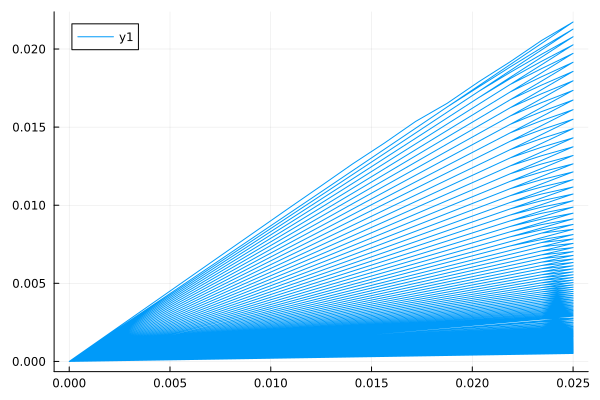

In [26]:
plot(Displacement,Load)

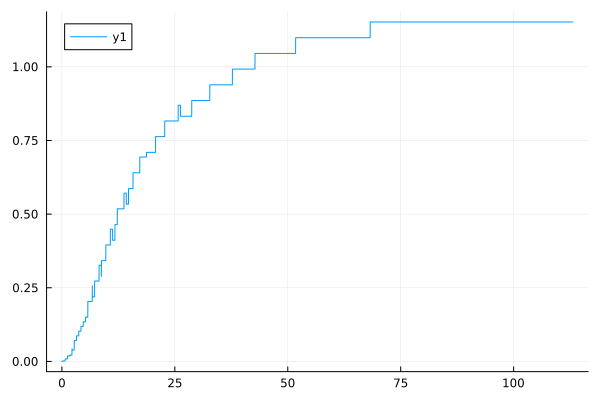

In [27]:
plot(NoofCycles,Yloccrack.-CH)

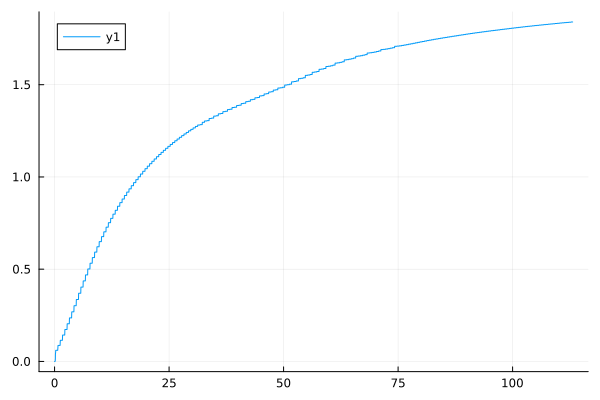

In [28]:
plot(NoofCycles,FracEnergy)

In [5]:
parent_path = "../PlottingFiles/"     # Go up one level and define the new folder name
mkpath(parent_path)

"../PlottingFiles"

In [6]:
cd("../PlottingFiles/")

In [30]:
using DelimitedFiles
using CSV
using Plots

In [31]:
using LaTeXStrings

In [32]:
NoofCyclesCSV = writedlm("kf05_Step64NoofCyclesPhlsfullVolDevNew$ls.csv",  NoofCycles, ',')
FracEnergyCSV = writedlm("kf05_Step64FracEnergyPhlsfullVolDevNew$ls.csv",  FracEnergy, ',')

In [33]:
NoofCyclesCSV = writedlm("kf05_Step64NoofCyclesPhlsfullVolDevN$ls.csv",  NoofCycles, ',')
XloccrackCSV = writedlm("kf05_Step64XloccrackPhlsfullVolDevN$ls.csv",  Xloccrack, ',')
YloccrackCSV = writedlm("kf05_Step64YloccrackPhlsfullVolDevN$ls.csv",  Yloccrack, ',')
LoadCSV = writedlm("kf05_Step64LoadPhlsfullVolDevN$ls.csv",  Load, ',')
αDegradCSV = writedlm("kf05_Step64αDegradPhlsfullVolDevN$ls.csv",  αDegrad, ',')